In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.cluster import KMeans, MiniBatchKMeans

# CU Woot Math Method 2 for unsupervosed discovery of new behavior traits
## 1) Convert response field dictionary into a document
## 2) Develop word vector using term frequency - inverse document frequency
## 3) Use K-Means to cluster documents
## 4) Map traits to clusters to validate technique


In the first results presented to Woot Math a 100K sample of the entire data set was chosen. In this report, I'll start with the same type of analysis to develop the same heat map. In the meeting Sean and Brent suggested using just one of the qual_id and repeat the experiment and then look at the samples in clusers without traits. I'll do that in a subsequent analysis



## Part 1. Heat map with 100 K sample of all qual_id's

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
#reponses = db.anon_student_task_responses.find({'correct':False})[start:end]
reponses = db.anon_student_task_responses.find()[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.shape)

(100000, 27)


In [8]:
##  Make the documents to be analyzed

In [9]:
## Functions for turning dictionary into document

def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
    
        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans

In [10]:
# Makes the cut & paste below easier
df3 = df_responses

In [11]:
df3['response_doc'] = df3['response'].map(make_string)


In [12]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace('/','_'))
df3['response_doc'] = df3['response_doc'] + ' ' + df3['txt'] 
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

## Sample Documents

In [13]:
for idx in range(20):
    print ("Sample number:", idx, "\n", df3.iloc[idx]['response_doc'])

Sample number: 0 
   fraction_cblock_chains_ right_442 fraction_cblock_chains_ sum_ numerator_1 sum_ denominator_2 sum_ __as3_type_Fraction fraction_cblock_chains_  pieces_1_2 fraction_cblock_chains_ left_97 fraction_cblock_chains_ lcm_sum_ numerator_1 lcm_sum_ denominator_2 lcm_sum_ __as3_type_Fraction   plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_end_marker_noline.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_markers_start_marker.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_dog.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets_cms_wootmath_fractions_number_line_objects_cat_dog_trail.swf  den_2  fraction_input_value_1_2  num_1  fraction_cblock_total_count_1    fraction_cblock_counts_ 1_2_1   whole_   Use the 1/2 pieces to figure out how far the dog traveled.Answer: 1/2 
Sample number: 1 
  fraction_cb

In [14]:
data_samples = df3['response_doc']

In [15]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [16]:
print("Extracting tf-idf features ...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features ...
done in 8.222s.


In [17]:
# Number of clusters
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, random_state=62)

In [18]:
print("Clustering with %s" % km)
t0 = time()
km.fit(tfidf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=62, reassignment_ratio=0.01,
        tol=0.0, verbose=0)
done in 2.820s



In [19]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:\n" % i, end='')
    for ind in order_centroids[i, :30]:
        print(' --- %s\n' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0:
 --- bitmap_text_interp_
 --- bitmap_text_inputs_
 --- fraction_input_value_
 --- long
 --- input_a_2
 --- enter
 --- fraction
 --- bar
 --- answer
 --- sum
 --- numbers
 --- input_6
 --- input_a_6
 --- form
 --- simplest
 --- input_a_4
 --- 12
 --- input_a_3
 --- input_a_8
 --- input_b_12
 --- input_b_6
 --- equation_12
 --- equation_6
 --- 10
 --- input_b_8
 --- input_5
 --- input_b_4
 --- shaded
 --- input_a_5
 --- match

Cluster 1:
 --- fraction_cblock_chains_
 --- sum_
 --- lcm_sum_
 --- pieces_1_9
 --- denominator_9
 --- __as3_type_fraction
 --- numerator_1
 --- denominator_1
 --- fraction_cblock_counts_
 --- bar1_
 --- denominator_3
 --- numerator_2
 --- pieces_1_3
 --- fraction
 --- left_130
 --- fraction_cblock_containment_
 --- pieces_1
 --- left_90
 --- left_80
 --- bar2_
 --- bar
 --- left_200
 --- black
 --- numerator_4
 --- right_820
 --- 1_
 --- 1_3_
 --- 1_1
 --- numerator_3
 --- right_780

Cluster 2:
 --- pieces_1_12
 --- fraction_circ

In [20]:
df3['cluster_100'] = km.labels_

In [21]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [22]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [23]:
df_cluster_100 = df3.groupby('cluster_100')

In [24]:
df_trait_1.index.rename('cluster_100', inplace=True)
df_trait_2.index.rename('cluster_100', inplace=True)
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [25]:
df_traits = df_traits.drop('None', axis=1)

In [26]:
#df_traits_norm = (df_traits - df_traits.mean()) / (df_traits.max() - df_traits.min())
df_traits_norm = (df_traits  / (df_traits.sum()) )

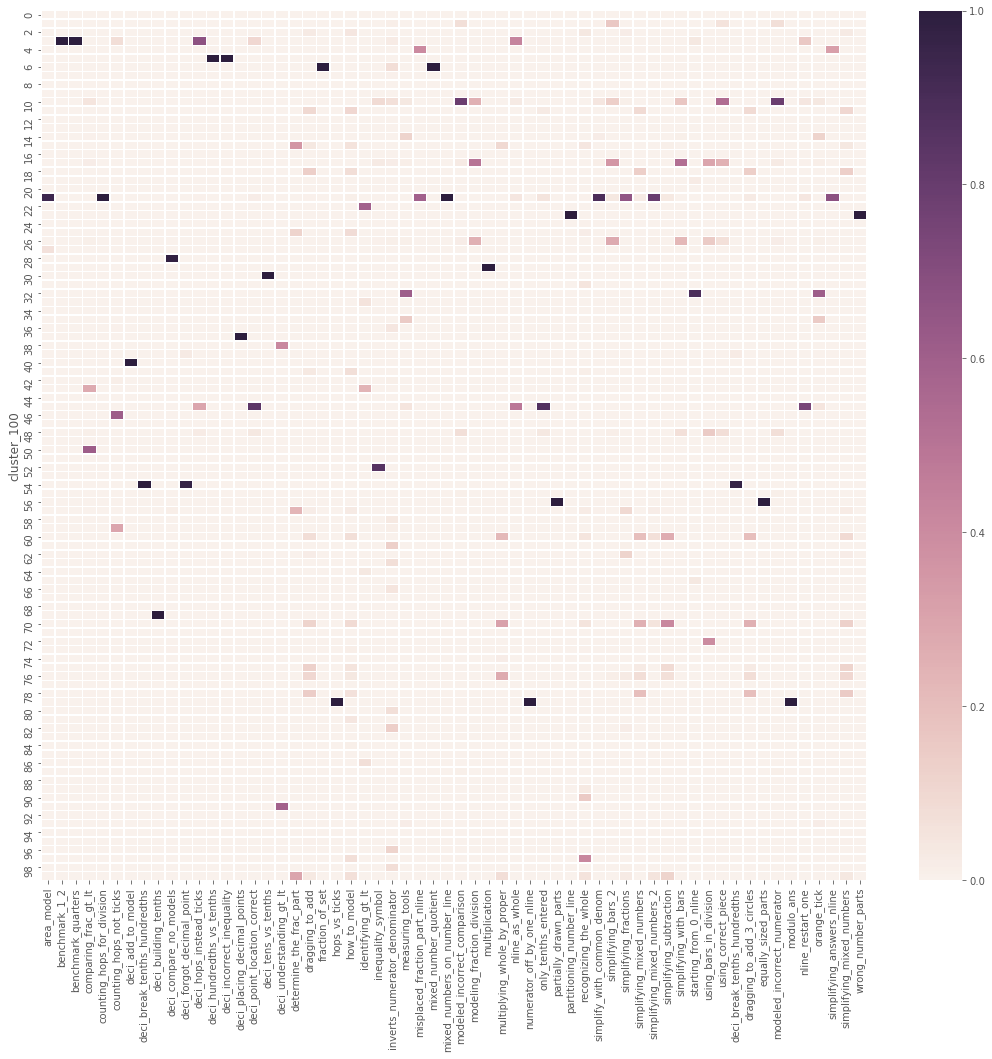

In [27]:
fig = plt.figure(figsize=(18.5, 16))
cmap = sns.cubehelix_palette(light=.95, as_cmap=True)
sns.heatmap(df_traits_norm, cmap=cmap,  linewidths=.5)

#sns.heatmap(df_traits_norm, cmap="YlGnBu",  linewidths=.5)